## Steps
- **Data gathering**
- **Create Recency Frequency Monetary (RFM) table**
- **Manage skewness and scale each variable**
- **Explore the data**
- **Cluster the data**
- **Interpret the result**

In [63]:
# Import The Libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [28]:
# Import The Dataset
df = pd.read_csv("OnlineRetail.csv", encoding= 'unicode_escape')
df = df[df['CustomerID'].notna()]

In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 406829 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    406829 non-null  object 
 1   StockCode    406829 non-null  object 
 2   Description  406829 non-null  object 
 3   Quantity     406829 non-null  int64  
 4   InvoiceDate  406829 non-null  object 
 5   UnitPrice    406829 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      406829 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 27.9+ MB


For this case, we don’t use all of the rows. Instead, we will sample 10000 rows from the dataset, and we assume that as the whole transactions that the customers do.
The code will look like this,

In [ ]:
# Sample the dataset
df_fix = df.sample(10000, random_state = 42)

In [2]:
df_fix

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
47912,540456,48185,DOORMAT FAIRY CAKE,2,1/7/2011 12:14,7.95,13534.0,United Kingdom
342630,566891,23013,GLASS APOTHECARY BOTTLE TONIC,4,9/15/2011 13:51,3.95,14894.0,United Kingdom
288183,C562139,21313,GLASS HEART T-LIGHT HOLDER,-4,8/3/2011 10:10,0.85,12921.0,United Kingdom
325368,565438,22382,LUNCH BAG SPACEBOY DESIGN,4,9/4/2011 13:56,1.65,17229.0,United Kingdom
331450,566016,21212,PACK OF 72 RETROSPOT CAKE CASES,24,9/8/2011 12:20,0.55,15144.0,United Kingdom
...,...,...,...,...,...,...,...,...
123,536381,22083,PAPER CHAIN KIT RETROSPOT,1,12/1/2010 9:41,2.95,15311.0,United Kingdom
449041,C575082,21843,RED RETROSPOT CAKE STAND,-4,11/8/2011 13:30,10.95,12613.0,Germany
425967,573340,21733,RED HANGING HEART T-LIGHT HOLDER,2,10/30/2011 11:55,2.95,14159.0,United Kingdom
70029,541997,22919,HERB MARKER MINT,5,1/25/2011 10:38,0.65,18077.0,United Kingdom


In [3]:
# converting the timestamp to date-time format
df_fix['InvoiceDate']= pd.to_datetime(df_fix['InvoiceDate'])

In [4]:
df_fix.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 47912 to 282657
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   InvoiceNo    10000 non-null  object        
 1   StockCode    10000 non-null  object        
 2   Description  10000 non-null  object        
 3   Quantity     10000 non-null  int64         
 4   InvoiceDate  10000 non-null  datetime64[ns]
 5   UnitPrice    10000 non-null  float64       
 6   CustomerID   10000 non-null  float64       
 7   Country      10000 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 703.1+ KB


In [6]:
# Convert to show date only
from datetime import datetime
df_fix["InvoiceDate"] = df_fix["InvoiceDate"].dt.date

In [7]:
df_fix

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
47912,540456,48185,DOORMAT FAIRY CAKE,2,2011-01-07,7.95,13534.0,United Kingdom
342630,566891,23013,GLASS APOTHECARY BOTTLE TONIC,4,2011-09-15,3.95,14894.0,United Kingdom
288183,C562139,21313,GLASS HEART T-LIGHT HOLDER,-4,2011-08-03,0.85,12921.0,United Kingdom
325368,565438,22382,LUNCH BAG SPACEBOY DESIGN,4,2011-09-04,1.65,17229.0,United Kingdom
331450,566016,21212,PACK OF 72 RETROSPOT CAKE CASES,24,2011-09-08,0.55,15144.0,United Kingdom
...,...,...,...,...,...,...,...,...
123,536381,22083,PAPER CHAIN KIT RETROSPOT,1,2010-12-01,2.95,15311.0,United Kingdom
449041,C575082,21843,RED RETROSPOT CAKE STAND,-4,2011-11-08,10.95,12613.0,Germany
425967,573340,21733,RED HANGING HEART T-LIGHT HOLDER,2,2011-10-30,2.95,14159.0,United Kingdom
70029,541997,22919,HERB MARKER MINT,5,2011-01-25,0.65,18077.0,United Kingdom


#### Create RFM Table
After we sample the data, we will make the data easier to conduct an analysis.
To segmenting customer, there are some metrics that we can use, such as when the customer buy the product for last time, how frequent the customer buy the product, and how much the customer pays for the product. We will call this segmentation as RFM segmentation.

To make the RFM table, we can create these columns, such as Recency, Frequency, and MonetaryValue column.
To get the number of days for recency column, we can subtract the snapshot date with the date where the transaction occurred.

To create the frequency column, we can count how much transactions by each customer.

Lastly, to create the monetary value column, we can sum all transactions for each customer.
The code looks like this,

In [8]:
# Create TotalSum colummn
df_fix["TotalSum"] = df_fix["Quantity"] * df_fix["UnitPrice"]

# Create date variable that records recency
import datetime
snapshot_date = max(df_fix.InvoiceDate) + datetime.timedelta(days=1)

# Aggregate data by each customer
customers = df_fix.groupby(['CustomerID']).agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
    'InvoiceNo': 'count',
    'TotalSum': 'sum'})

# Rename columns
customers.rename(columns = {'InvoiceDate': 'Recency', 'InvoiceNo': 'Frequency', 'TotalSum': 'MonetaryValue'}, inplace=True)

In [9]:
customers

,Recency,Frequency,MonetaryValue
CustomerID,,,
12347.0,40,5,133.20
12348.0,249,2,120.88
12349.0,19,2,312.75
12352.0,73,5,80.85
12354.0,233,2,33.30
...,...,...,...
18265.0,73,2,39.60
18272.0,3,11,206.17
18274.0,18,2,-4.65


Right now, the dataset consists of recency, frequency, and monetary value column. But we cannot use the dataset yet because we have to preprocess the data more.

### Manage Skewness and Scaling
We have to make sure that the data meet these assumptions, they are,
- The data should meet assumptions where the variables are not skewed and 
- have the same mean and variance.

Because of that, we have to manage the skewness of the variables.
Here are the visualizations of each variable,

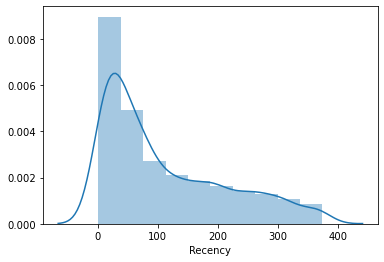

In [52]:
sns.distplot(customers['Recency'], kde=True, bins=10)

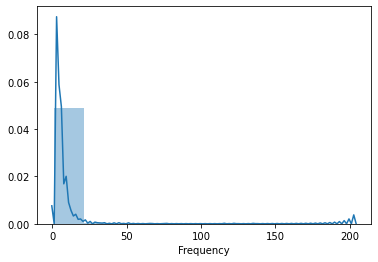

In [53]:
sns.distplot(customers['Frequency'], kde=True, bins=10)

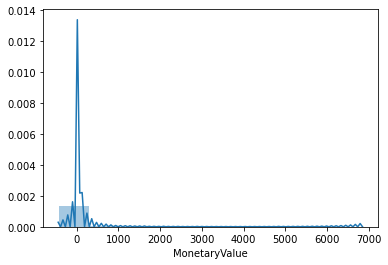

In [54]:
sns.distplot(customers['MonetaryValue'], kde=True, bins=10)

As we can see from above, we have to transform the data, so it has a more symmetrical form.

There are some methods that we can use to manage the skewness, they are,

* log transformation
* square root transformation
* box-cox transformation

*Note:* We can use the transformation if and only if the variable only has positive values.

Below are the visualization each variable with box-cox transformation.

In [77]:
# import modules
import numpy as np
from scipy import stats

import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy.stats import boxcox
import seaborn as sns
from IPython.display import HTML

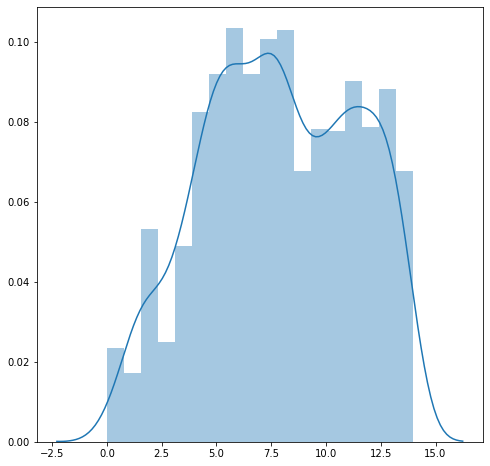

In [88]:
Recency = boxcox(customers['Recency'])[0]
plt.figure(figsize = (8, 8))
sns.distplot(Recency)
plt.show()

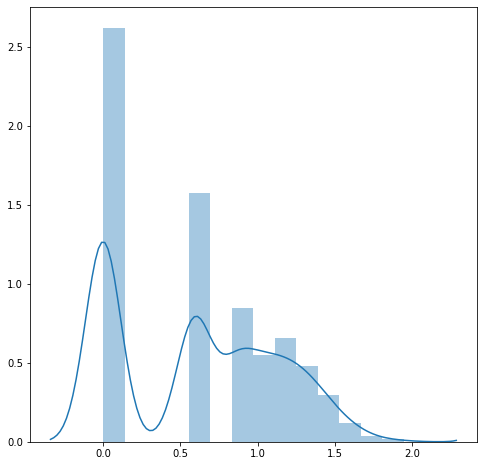

In [89]:
Frequency = boxcox(customers['Frequency'])[0]
plt.figure(figsize = (8, 8))
sns.distplot(Frequency)
plt.show()

Based on that visualization, it shows that the variables with box-cox transformation shows a more symmetrical form rather than the other transformations.
To make sure, we calculate each variable using the skew function. The result looks like this,

In [106]:
from scipy.stats import skew
print("Recency = ", skew(Recency))
print("Frequency = ", skew(Frequency))

Recency =  -0.10309005355465052
Frequency =  0.16176250323330582


Here is how to interpret the skewness value. If the value is close to 0, the variable tend to have symmetrical form. However, if it’s not, the variable has skew on it. Based on that calculation, we use variables that use box-cox transformations.

Based on that calculation, we will utilize variables that use box-cox transformations. Except for the MonetaryValue variable because the variable includes negative values. To handle this variable, we can use cubic root transformation to the data.

By using the transformation, we will have data that is less skewed. The skewness value declines from 16.63 to 1.16. Therefore, we can transform the RFM table with this code,

In [90]:
from scipy import stats
customers_fix = pd.DataFrame()
customers_fix["Recency"] = stats.boxcox(customers['Recency'])[0]
customers_fix["Frequency"] = stats.boxcox(customers['Frequency'])[0]
customers_fix["MonetaryValue"] = pd.Series(np.cbrt(customers['MonetaryValue'])).values
customers_fix.tail()

,Recency,Frequency,MonetaryValue
2685,7.832068,0.591193,3.408514
2686,1.269495,1.435599,5.907565
2687,4.288385,0.591193,-1.669108
2688,1.665555,1.615329,4.273206
2689,6.340700,1.017445,4.087250


We can't use the data yet. If we look at the plot once more, each variable don’t have the same mean and variance. We have to normalize it. To normalize, we can use StandardScaler object from scikit-learn library to do it. The code will look like this,

In [91]:
# Import library
from sklearn.preprocessing import StandardScaler

# Initialize the Object
scaler = StandardScaler()

# Fit and Transform The Data
scaler.fit(customers_fix)
customers_normalized = scaler.transform(customers_fix)

# Assert that it has mean 0 and variance 1
print(customers_normalized.mean(axis = 0).round(2)) # [0. -0. 0.]
print(customers_normalized.std(axis = 0).round(2)) # [1. 1. 1.]

[ 0. -0.  0.]
[1. 1. 1.]


In [92]:
customers_fix

,Recency,Frequency,MonetaryValue
0,6.152222,1.127547,5.107026
1,12.180045,0.591193,4.944452
2,4.402867,0.591193,6.787853
3,7.832068,1.127547,4.324076
4,11.907953,0.591193,3.217225
...,...,...,...
2685,7.832068,0.591193,3.408514
2686,1.269495,1.435599,5.907565
2687,4.288385,0.591193,-1.669108
2688,1.665555,1.615329,4.273206


Finally, we can do clustering using that data.

### Modelling
Right after we preprocess the data, now we can focus on modelling. To make segmentation from the data, we can use the K-Means algorithm to do this.

K-Means algorithm is an unsupervised learning algorithm that uses the geometrical principle to determine which cluster belongs to the data. By determine each centroid, we calculate the distance to each centroid. Each data belongs to a centroid if it has the smallest distance from the other. It repeats until the next total of the distance doesn’t have significant changes than before.

We can use the KMeans function from scikit-learn to do this.
To make our clustering reach its maximum performance, we have to determine which hyperparameter fits to the data. To determine which hyperparameter is the best for our model and data, we can use the elbow method to decide. The code will look like this,

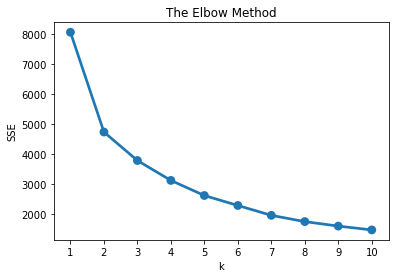

In [93]:
import seaborn as sns
from sklearn.cluster import KMeans
sse = {}
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(customers_normalized)
    sse[k] = kmeans.inertia_ # SSE to closest cluster centroid
plt.title('The Elbow Method')
plt.xlabel('k')
plt.ylabel('SSE')
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()

#### How to interpret the plot? 
The x-axis is the value of the k, and the y-axis is the SSE value of the data. We will take the best parameter by looking at where the k-value will have a linear trend on the next consecutive k.
Based on our observation, the k-value of 3 is the best hyperparameter for our model because the next k-value tend to have a linear trend. Therefore, our best model for the data is K-Means with the number of clusters is 3.
Now, We can fit the model with this code,

In [94]:
model = KMeans(n_clusters=3, random_state=42)
model.fit(customers_normalized)
model.labels_.shape

(2690,)

By fitting the model, we can have clusters where each data belongs. By that, we can analyze the data.

### Interpret The Segment
We can summarize the RFM table based on clusters and calculate the mean of each variable. The code will look like this,

In [95]:
customers["Cluster"] = model.labels_
customers.groupby('Cluster').agg({
    'Recency':'mean',
    'Frequency':'mean',
    'MonetaryValue':['mean', 'count']}).round(2)

Recency Frequency MonetaryValue      
           mean      mean          mean count
Cluster                                      
0         47.21      1.62         21.58   808
1        226.64      1.64         28.66   960
2         46.31      7.72        166.06   922

Besides that, we can analyze the segments using snake plot. It requires the normalized dataset and also the cluster labels. By using this plot, we can have a good visualization from the data on how the cluster differs from each other. We can make the plot by using this code,

In [107]:
# Create the dataframe
df_normalized = pd.DataFrame(customers_normalized, columns=['Recency', 'Frequency', 'MonetaryValue'])
df_normalized['ID'] = customers.index
df_normalized['Cluster'] = model.labels_

# Melt The Data
df_nor_melt = pd.melt(df_normalized.reset_index(),
                      id_vars=['ID', 'Cluster'],
                      value_vars=['Recency','Frequency','MonetaryValue'],
                      var_name='Attribute',
                      value_name='Value')
df_nor_melt.head()

,ID,Cluster,Attribute,Value
0,12347.0,2,Recency,-0.493794
1,12348.0,1,Recency,1.232949
2,12349.0,2,Recency,-0.994917
3,12352.0,2,Recency,-0.012582
4,12354.0,1,Recency,1.155005


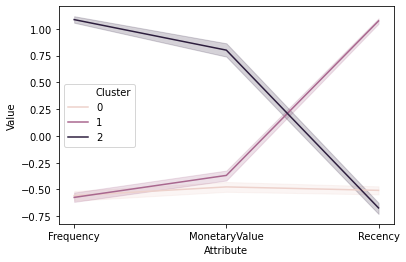

In [108]:
# Visualize it
sns.lineplot('Attribute', 'Value', hue='Cluster', data=df_nor_melt)

By using this plot, we know how each segment differs. It describes more than we use the summarized table.

We infer that cluster 2 is frequent, spend more, and they buy the product recently. Therefore, it could be the cluster of a loyal customer.

Then, the cluster 0 is less frequent, less to spend, but they buy the product recently. Therefore, it could be the cluster of new customer.

Finally, the cluster 1 is less frequent, less to spend, and they buy the product at the old time. Therefore, it could be the cluster of churned customers.